# New LSTM Oslo PM2.5

Trial 1 Complete [00h 06m 10s]
val_loss: 1.011940836906433

Best val_loss So Far: 1.011940836906433
Total elapsed time: 00h 06m 10s
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 1.3040 - val_loss: 1.2154
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.4228 - val_loss: 1.1507
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.2594 - val_loss: 1.1163
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.2090 - val_loss: 1.1075
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.2556 - val_loss: 1.1001
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.2370 - val_loss: 1.0868
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.2063 - val_loss: 1.0672
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.1192 - val_loss: 1.0603
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.1206 - val_loss: 1.0570
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.0745 - val_loss: 1.0527
Epoch 11/50
69/6

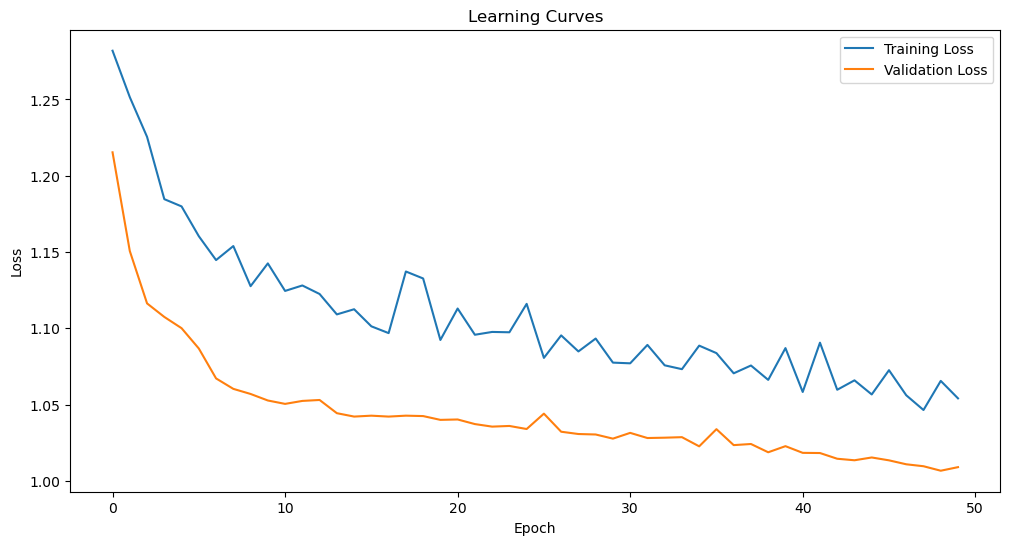

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
LSTM Model Results:
Time steps: 2, Forecast days: 7
Test Loss: 1.074539303779602
Test MAE: 0.6089305674858304
Test RMSE: 1.0322325970505988

Time steps: 2, Forecast days: 10
Test Loss: 1.0846834182739258
Test MAE: 0.5935036255761234
Test RMSE: 1.0379694582968055

Time steps: 3, Forecast days: 7
Test Loss: 1.0625847578048706
Test MAE: 0.6057664783943116
Test RMSE: 1.0276778728606908

Time steps: 3, Forecast days: 10
Test Loss: 1.0893642902374268
Test MAE: 0.6162413213329135
Test RMSE: 1.0440571493752129

Time steps: 4, Forecast days: 7
Test Loss: 1.1779930591583252
Test MAE: 0.5944844640573781
Test RMSE: 1.0814066832447837

Time steps: 4, Forecast days: 10
Test Loss: 1.0670379400253296
Test MAE: 0.5997604769802465
Test RMSE: 1.023383922986182

Time steps: 5, Forecast days: 7
Test Loss: 1.0595704317092896
Test MAE: 0.5778634606403539
Test RMSE: 1.021430245466007

Time steps: 5, Forecast days: 10
Test Loss: 1.0099011659622192
Test MAE: 0.56236888931

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kerastuner import HyperModel, RandomSearch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy import stats

# Load data
df = pd.read_excel("PM25Oslo.xlsx")

# Extract features and target variable
X = df[["TV", "Tmean", "HDD", "VP", "WS", "WG", "meanRH", "SD", "PP"]]
Y = df["PM25"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(data, target, time_steps, forecast_days):
    sequences = []
    targets = []
    for i in range(len(data) - time_steps - forecast_days + 1):
        sequences.append(data[i:i + time_steps])
        targets.append(target[i + time_steps:i + time_steps + forecast_days])
    return np.array(sequences), np.array(targets)

def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

# List of different time steps to test
time_steps_list = [2, 3, 4, 5, 6, 7]
forecast_days_list = [7, 10]

# Dictionary to hold train and test data for each time step and forecast day
data_dict = {}

for time_steps in time_steps_list:
    for forecast_days in forecast_days_list:
        X_seq, y_seq = create_sequences(X_scaled, Y, time_steps, forecast_days)
        X_train_seq, X_temp_seq, y_train_seq, y_temp_seq = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42)
        X_val_seq, X_test_seq, y_val_seq, y_test_seq = train_test_split(X_temp_seq, y_temp_seq, test_size=0.5, random_state=42)
        data_dict[(time_steps, forecast_days)] = (X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq)

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, forecast_days):
        self.input_shape = input_shape
        self.forecast_days = forecast_days

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=16),
                              activation='relu',
                              return_sequences=True,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              input_shape=self.input_shape))
        model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.4, 0.6, 0.8])))

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(layers.LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=16),
                                  activation='relu',
                                  return_sequences=True))
            model.add(layers.Dropout(rate=hp.Choice(f'dropout_rate_{i}', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(layers.LSTM(units=hp.Int('units_last', min_value=32, max_value=512, step=16),
                              activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(layers.Dropout(rate=hp.Choice('dropout_rate_last', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(layers.Dense(self.forecast_days))
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')
        return model

results = {}
history_dict = {}  # To store history for learning curves

for time_steps in time_steps_list:
    for forecast_days in forecast_days_list:
        X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq = data_dict[(time_steps, forecast_days)]
        input_shape = (time_steps, X_train_seq.shape[2])

        # Define and tune the model
        hypermodel = MyHyperModel(input_shape=input_shape, forecast_days=forecast_days)
        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=1,
            executions_per_trial=2,
            directory=f'my_dir_{time_steps}_{forecast_days}',
            project_name='PM25_prediction')

        tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq))
        
        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Build final model with best hyperparameters
        final_model = tuner.hypermodel.build(best_hps)
        
        # Train the model
        history = final_model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), verbose=1)
        history_dict[(time_steps, forecast_days)] = history
        
        # Plot learning curves
        plot_learning_curves(history)
        
        # Evaluate the model
        y_pred = final_model.predict(X_test_seq)
        test_loss = final_model.evaluate(X_test_seq, y_test_seq, verbose=0)
        
        # Additional evaluation metrics
        test_mae = mean_absolute_error(y_test_seq, y_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
        
        results[(time_steps, forecast_days)] = {
            'loss': test_loss,
            'mae': test_mae,
            'rmse': test_rmse
        }

# Print results for LSTM models
print("LSTM Model Results:")
for (time_steps, forecast_days), metrics in results.items():
    print(f"Time steps: {time_steps}, Forecast days: {forecast_days}")
    print(f"Test Loss: {metrics['loss']}")
    print(f"Test MAE: {metrics['mae']}")
    print(f"Test RMSE: {metrics['rmse']}")
    print("")

# Train and evaluate a Linear Regression model
print("Linear Regression Model Results:")

# Flatten data for linear regression
X_flat = X_scaled[time_steps_list[0] - 1:]  # Use the data for the minimum time_steps
Y_flat = Y[time_steps_list[0] - 1:]  # Corresponding target variable
X_train_flat, X_temp_flat, y_train_flat, y_temp_flat = train_test_split(X_flat, Y_flat, test_size=0.4, random_state=42)
X_val_flat, X_test_flat, y_val_flat, y_test_flat = train_test_split(X_temp_flat, y_temp_flat, test_size=0.5, random_state=42)

# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_flat)

# Predict and evaluate
y_pred_lin = lin_reg.predict(X_test_flat)
lin_test_mae = mean_absolute_error(y_test_flat, y_pred_lin)
lin_test_rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_lin))

print(f"Test MAE: {lin_test_mae}")
print(f"Test RMSE: {lin_test_rmse}")
print("")

# Feature importance analysis using permutation importance
print("Feature Importance Analysis:")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_flat, Y_flat)
result = permutation_importance(model_rf, X_flat, Y_flat, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature: {X.columns[i]}, Importance: {result.importances_mean[i]}")

# Statistical hypothesis testing

# Extract the LSTM results for T-Test
lstm_losses = np.array([metrics['loss'] for metrics in results.values()])

# comparing two groups
group1_losses = lstm_losses[:len(lstm_losses)//2]  # First half of the results
group2_losses = lstm_losses[len(lstm_losses)//2:]  # Second half of the results

# Perform independent T-Test
t_stat, p_value = stats.ttest_ind(group1_losses, group2_losses)
print("Independent T-Test Results")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Perform ANOVA
# For simplicity, using all LSTM results as different groups
f_stat, p_value_anova = stats.f_oneway(*[lstm_losses[i:i+len(lstm_losses)//len(time_steps_list)] for i in range(0, len(lstm_losses), len(lstm_losses)//len(time_steps_list))])
print("ANOVA Test Results")
print("F-Statistic:", f_stat)
print("P-Value:", p_value_anova)

# Policy Recommendations
print("\nPolicy Recommendations:")

# If LSTM models perform better than Linear Regression (based on lower MAE and RMSE)
if np.mean([metrics['rmse'] for metrics in results.values()]) < lin_test_rmse:
    print("1. The LSTM models outperform the Linear Regression model in terms of prediction accuracy. Policies should consider using advanced models like LSTM for better air quality forecasting.")

# Based on feature importance, recommend policies targeting key features
important_features = [X.columns[i] for i in result.importances_mean.argsort()[::-1]]
print("2. Based on feature importance, focus on improving conditions related to the most important features:")
for feature in important_features[:5]:  # Top 5 features
    print(f"- {feature}: Implement measures to reduce or control the impact of {feature}.")

# General recommendations based on evaluation metrics
if np.mean([metrics['mae'] for metrics in results.values()]) < lin_test_mae:
    print("3. Consider implementing policies that address the factors contributing to PM2.5 emissions, as indicated by the features with high importance scores, to reduce overall pollution levels.")
else:
    print("4. Continue monitoring and refining models to achieve better predictive performance, which can guide more effective policy interventions.")

